<a href="https://colab.research.google.com/github/GUNTERMAXIMUS/covid-19predictCL/blob/master/covod_19_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
try:
  %tensorflow_version 2.x
except OSError:
  print(tf.__version__)
finally:
  import tensorflow as tf
  from tensorflow.keras import Sequential
  from tensorflow.keras.layers import Dense, LSTM, Dropout
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  
  import requests as rq
  import io
  
  print(f'TF version: {tf.__version__}')
  
#  from google.colab import drive
#  drive.mount('/content/gdrive', force_remount = True, timeout_ms = 60000)


TF version: 2.2.0-rc2


In [0]:
url = 'https://raw.githubusercontent.com/GUNTERMAXIMUS/covid-19predictCL/master/covid_19_data.csv'

respond = rq.get(url).content

df_data = pd.read_csv(io.StringIO(respond.decode('utf-8')), 
                      sep = ',', 
                      quotechar = '"', 
                      usecols = [1, 3, 5, 6 , 7],
                      encoding = 'utf-8'
                      )

df_train = pd.read_csv(io.StringIO(respond.decode('utf-8')), 
                      sep = ',', 
                      quotechar = '"', 
                      usecols = [1, 3, 5, 6 , 7], 
                      encoding = 'utf-8'
                      )

In [47]:
df = df_data[df_data['Country/Region'].str.contains('Chile')].dropna()
df_train.dropna()
print(df.isnull().any())
df.tail(10)

ObservationDate    False
Country/Region     False
Confirmed          False
Deaths             False
Recovered          False
dtype: bool


,ObservationDate,Country/Region,Confirmed,Deaths,Recovered
9148,03/27/2020,Chile,1610.0,5.0,43.0
9455,03/28/2020,Chile,1909.0,6.0,61.0
9766,03/29/2020,Chile,2139.0,7.0,75.0
10078,03/30/2020,Chile,2449.0,8.0,156.0
10391,03/31/2020,Chile,2738.0,12.0,156.0
10704,04/01/2020,Chile,3031.0,16.0,234.0
11017,04/02/2020,Chile,3404.0,18.0,335.0
11332,04/03/2020,Chile,3737.0,22.0,427.0
11647,04/04/2020,Chile,4161.0,27.0,528.0
11963,04/05/2020,Chile,4471.0,34.0,618.0


In [77]:
gr = np.array((df.Confirmed) - (df.Recovered + df.Deaths))
growth_rate = ((gr[-1] - gr[-2]) / gr[-2]) * 100
growth_rate

5.906821963394343

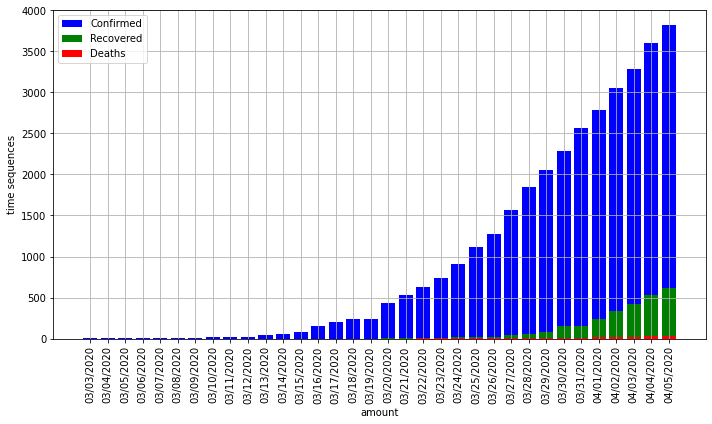

In [19]:
x = df.ObservationDate
y = (df.Confirmed) - (df.Recovered + df.Deaths)

plt.figure(figsize = (10, 6))
plt.bar(x, y, label = 'Confirmed', color = 'blue')
plt.bar(x, df.Recovered, label = 'Recovered', color = 'green')
plt.bar(x, df.Deaths, label = 'Deaths', color = 'red')
#plt.stackplot(x, df.Confirmed, df.Recovered, df.Deaths)
plt.xlabel('amount', )
plt.ylabel('time sequences')
plt.legend(loc = 'upper left')
plt.xticks(rotation = 'vertical')
plt.tight_layout()
plt.grid(True)

plt.show()

In [0]:
dates = df.ObservationDate
confirmed = np.array([int(i) for i in y]).reshape(-1, 1)
deaths = np.array([int(i) for i in df.Deaths]).reshape(-1, 1)
recovered = np.array([int(i) for i in df.Recovered]).reshape(-1, 1)
mortality_rate = np.array(df['Deaths'].tail(1) / df['Confirmed'].tail(1).sum()).reshape(-1, 1)

confirmed_total = df.Confirmed.tail(1)

days = np.array([i for i in range(len(dates))]).reshape(-1, 1)
deaths_total = np.array(df.Deaths.tail(1)).reshape(-1, 1)
recovered_total = np.array(df.Recovered.tail(1)).reshape(-1, 1)

In [21]:
mortality_rate = ((df.Deaths.tail(1) / df.Confirmed.tail(1)).sum()) * 100
print(f'Mortality rate: {mortality_rate} %')

Mortality rate: 0.7604562737642585 %


In [0]:
days_future = 30
future_forecast_days = np.array([i for i in range(len(dates) + days_future)]).reshape(-1, 1)
adjusted_dates = future_forecast_days[:-30]

In [0]:
# convert integers into date time for visualization
import datetime
start_date = datetime.datetime.strptime('03/03/2020', '%m/%d/%Y')
future_forecaste_dates = []

for i in range(len(future_forecast_days)):
  future_forecaste_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [0]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import operator

In [0]:
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel':kernel, 'C':c, 'gamma':gamma,'epsilon':epsilon,'shrinking':shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring = 'neg_mean_squared_error', cv=3, return_train_score=True, 
                                n_jobs=-1, n_iter=140, verbose=1)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days, confirmed, test_size=0.15, shuffle=False)

In [26]:
svm_search.fit(X_train_confirmed, y_train_confirmed.ravel())

Fitting 3 folds for each of 140 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  3.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=140, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['poly', 'sigmoid', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [27]:
svm_search.best_params_

{'C': 10, 'epsilon': 1, 'gamma': 1, 'kernel': 'poly', 'shrinking': True}

In [28]:
svm_confirmed = svm_search.best_estimator_
svm_prediction = svm_confirmed.predict(future_forecast_days)

print(svm_confirmed)
print(svm_prediction)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma=1,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[-5.49667406e+01 -5.48584182e+01 -5.41001609e+01 -5.20420342e+01
 -4.80341031e+01 -4.14264330e+01 -3.15690891e+01 -1.78121365e+01
  4.94359315e-01  2.40003334e+01  5.33557202e+01  8.92104548e+01
  1.32214472e+02  1.83017706e+02  2.42270092e+02  3.10621565e+02
  3.88722059e+02  4.77221510e+02  5.76769851e+02  6.88017018e+02
  8.11612946e+02  9.48207569e+02  1.09845082e+03  1.26299264e+03
  1.44248296e+03  1.63757171e+03  1.84890883e+03  2.07714426e+03
  2.32292792e+03  2.58690976e+03  2.86973970e+03  3.17206769e+03
  3.49454366e+03  3.83781753e+03  4.20253926e+03  4.58935877e+03
  4.99892600e+03  5.43189087e+03  5.88890333e+03  6.37061331e+03
  6.87767075e+03  7.41072558e+03  7.97042774e+03  8.55742715e+03
  9.17237377e+03  9.81591751e+03  1.04887083e+04  1.11913961e+04
  1.19246309e+04  1.26890625e+04  1.34853409e+04  1.43141160e+04
  1.51760378e+

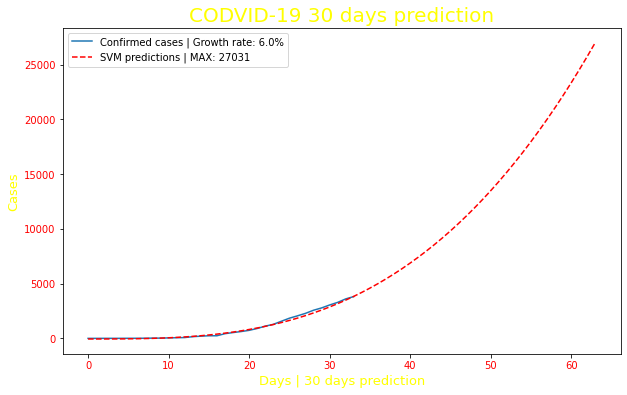

In [83]:
plt.figure(figsize = (10, 6))
plt.plot(adjusted_dates, y)
plt.plot(future_forecast_days, svm_prediction, linestyle='dashed', color='red')
plt.title('CODVID-19 30 days prediction', size = 20, color = 'yellow')
plt.xlabel('Days | 30 days prediction', size = 13, color = 'yellow')
plt.ylabel('Cases', size = 13, color = 'yellow')
plt.legend([f'Confirmed cases | Growth rate: {round(growth_rate)}%', f'SVM predictions | MAX: {int(round(svm_prediction[-1]))}'])
plt.xticks(size=10, color = 'red')
plt.yticks(size=10, c = 'red')
plt.show()